### Plotting Benchmarks

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# --- 1. Define Paths and Find Files ---
METRICS_PATH = './'
# Use glob to find all files in the directory that end with '_metrics.csv'
all_files = glob.glob(os.path.join(METRICS_PATH, "*_metrics.csv"))

# --- 2. Load and Concatenate Data ---
# Create an empty list to hold the individual DataFrames
df_list = []

# Loop through the list of found files
for filename in all_files:
    # Read each CSV file and append its DataFrame to the list
    df_list.append(pd.read_csv(filename))

# Concatenate all DataFrames in the list into a single, master DataFrame
# ignore_index=True re-creates a clean index for the new combined DataFrame.
if df_list:
    df = pd.concat(df_list, ignore_index=True)
    print(f"Successfully loaded and concatenated {len(df_list)} metric files.")
else:
    print("Warning: No metric files found in the specified directory.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later

# --- 3. Process the Combined Data (Your original code) ---
# Ensure the 'Compiler' column is treated as a string
df['Compiler'] = df['Compiler'].astype(str)

# Filter to get only the rows with individual runs (1, 2, 3, etc.)
df_runs = df[pd.to_numeric(df['Run'], errors='coerce').notnull()].copy()
df_runs['Run'] = df_runs['Run'].astype(int)

# Create the 'TotalCPUTime_s' column by combining 'UserTime_s' and 'SysTime_s'
df_runs['TotalCPUTime_s'] = df_runs['UserTime_s'] + df_runs['SysTime_s']

# Create the "warm runs" DataFrame (excluding run 1)
warm_runs_df = df_runs[df_runs['Run'] > 1].copy()

# Set a consistent plot style for all graphs
plt.style.use('seaborn-v0_8-whitegrid')

Successfully loaded and concatenated 7 metric files.


In [15]:
warm_runs_df

,Compiler,Run,RealTime_s,UserTime_s,SysTime_s,TotalCPUTime_s
1,preserve_none_fdo_clang,2,128.74,7060.14,364.48,7424.62
2,preserve_none_fdo_clang,3,128.23,7068.62,365.47,7434.09
3,preserve_none_fdo_clang,4,127.73,7076.43,366.90,7443.33
4,preserve_none_fdo_clang,5,128.59,7071.62,367.27,7438.89
5,preserve_none_fdo_clang,6,128.13,7070.45,365.50,7435.95
...,...,...,...,...,...,...
197,ipra_thinly_linked_fdo_clang,26,124.27,6817.62,376.89,7194.51
198,ipra_thinly_linked_fdo_clang,27,123.32,6809.85,380.42,7190.27
199,ipra_thinly_linked_fdo_clang,28,125.52,6825.61,384.49,7210.10
200,ipra_thinly_linked_fdo_clang,29,125.15,6824.19,383.54,7207.73


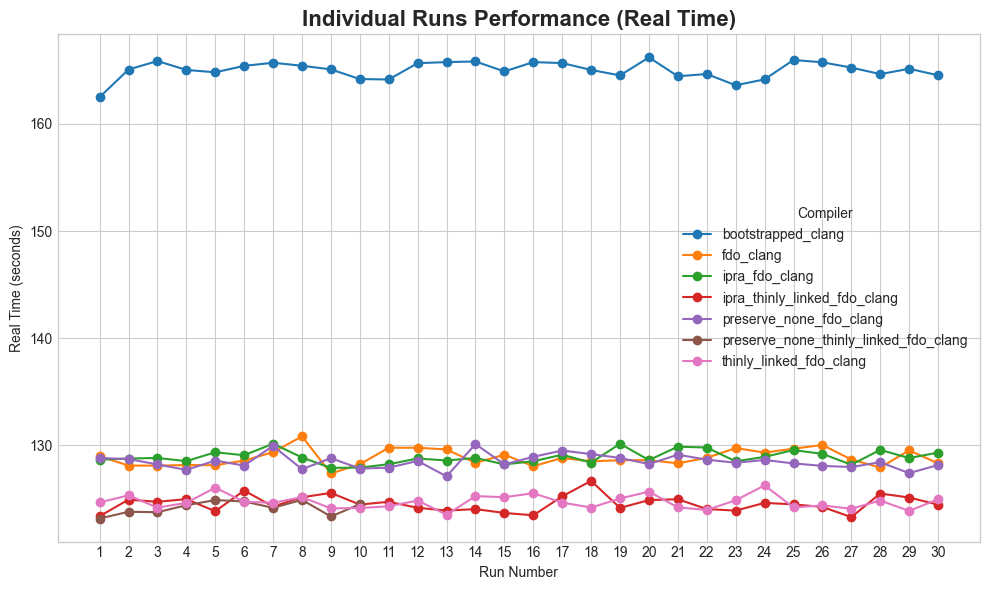

In [16]:
# --- 2. Generate Plots for Real Time ---

# 2a. Individual Runs - Real Time
pivot_real = df_runs.pivot(index='Run', columns='Compiler', values='RealTime_s')
fig, ax = plt.subplots(figsize=(10, 6))
pivot_real.plot(kind='line', marker='o', ax=ax)
ax.set_title('Individual Runs Performance (Real Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Real Time (seconds)')
ax.set_xlabel('Run Number')
ax.legend(title='Compiler')
ax.set_xticks(df_runs['Run'].unique())
plt.tight_layout()
plt.show()

/tmp/ipykernel_1954351/919862672.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_real.index, rotation=0)


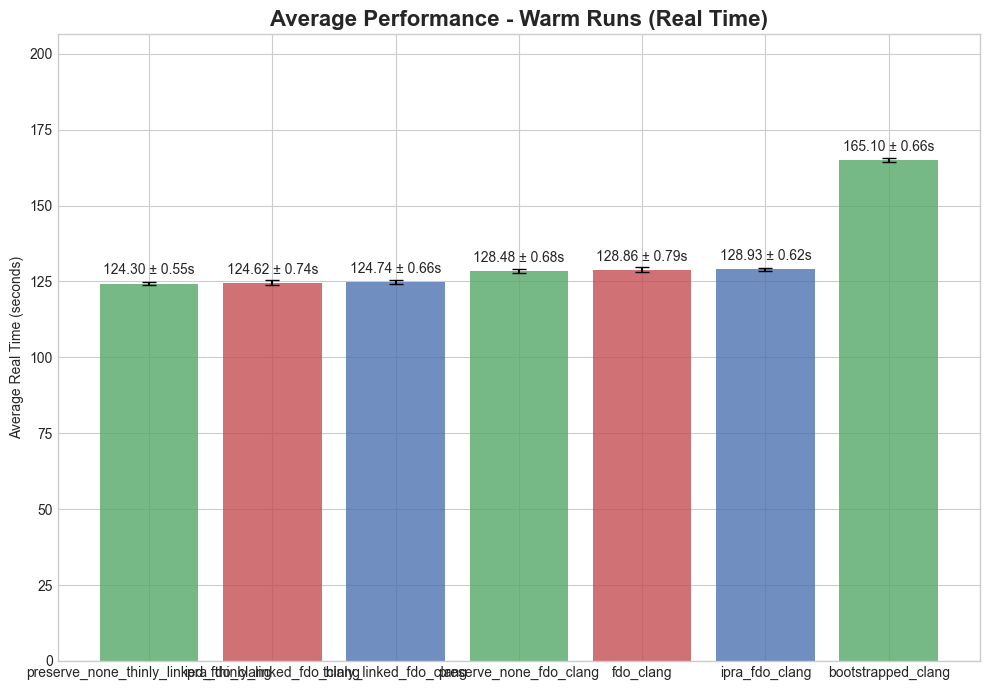

In [17]:
# 2b. Average Performance (Warm Runs) - Real Time
avg_real = warm_runs_df.groupby('Compiler')['RealTime_s'].mean().sort_values()
std_real = warm_runs_df.groupby('Compiler')['RealTime_s'].std().reindex(avg_real.index)
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(avg_real.index, avg_real, yerr=std_real, capsize=5,
              color=['#55a868', '#c44e52', '#4c72b0'], alpha=0.8)
ax.set_title('Average Performance - Warm Runs (Real Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Average Real Time (seconds)')
ax.set_xticklabels(avg_real.index, rotation=0)
ax.set_ylim(0, avg_real.max() * 1.25)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    avg_val = avg_real.iloc[i]
    std_val = std_real.iloc[i]
    label = f'{avg_val:.2f} ± {std_val:.2f}s'
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 2, label, ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

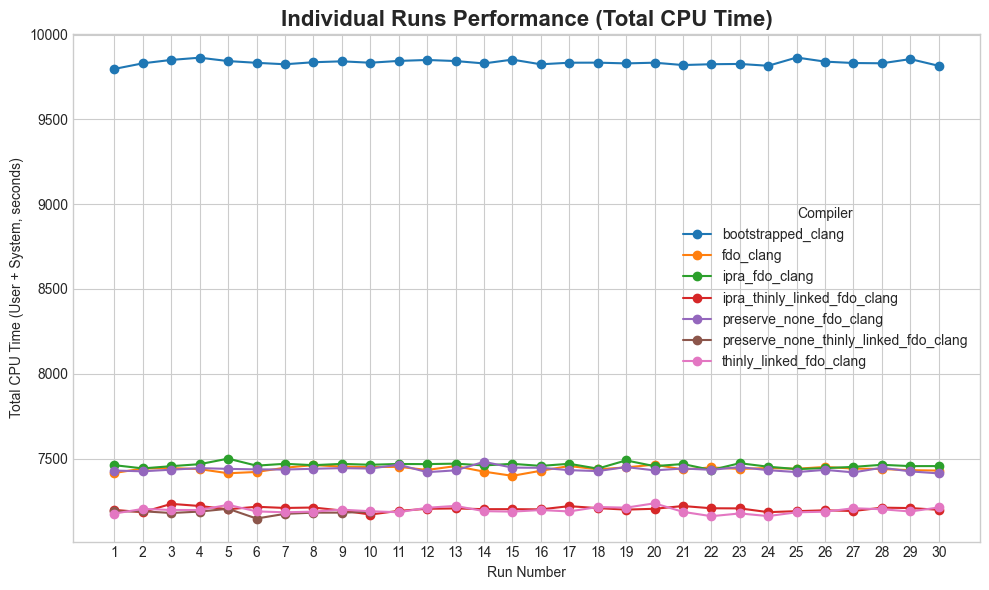

In [18]:
# --- 3. Generate Plots for Total CPU Time ---
# 3a. Individual Runs - Total CPU Time
pivot_cpu = df_runs.pivot(index='Run', columns='Compiler', values='TotalCPUTime_s')
fig, ax = plt.subplots(figsize=(10, 6))
pivot_cpu.plot(kind='line', marker='o', ax=ax)
ax.set_title('Individual Runs Performance (Total CPU Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Total CPU Time (User + System, seconds)')
ax.set_xlabel('Run Number')
ax.legend(title='Compiler')
ax.set_xticks(df_runs['Run'].unique())
plt.tight_layout()
plt.show()


/tmp/ipykernel_1954351/1953169525.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_cpu.index, rotation=0)


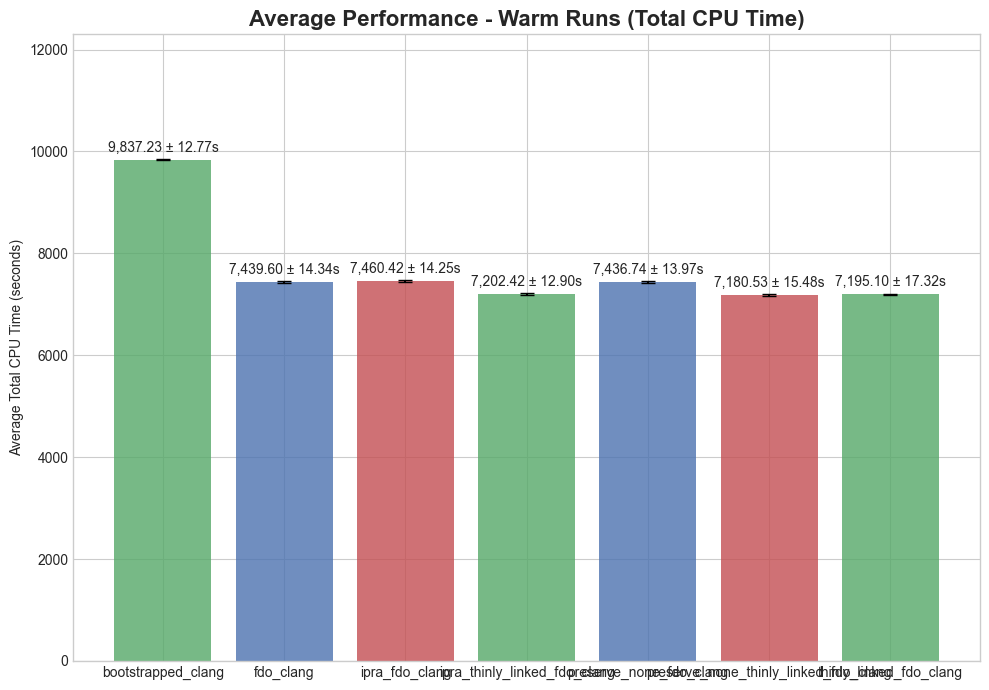

In [19]:
# 3b. Average Performance (Warm Runs) - Total CPU Time
avg_cpu = warm_runs_df.groupby('Compiler')['TotalCPUTime_s'].mean()
std_cpu = warm_runs_df.groupby('Compiler')['TotalCPUTime_s'].std().reindex(avg_cpu.index)
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(avg_cpu.index, avg_cpu, yerr=std_cpu, capsize=5,
              color=['#55a868', '#4c72b0', '#c44e52'], alpha=0.8)
ax.set_title('Average Performance - Warm Runs (Total CPU Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Average Total CPU Time (seconds)')
ax.set_xticklabels(avg_cpu.index, rotation=0)
ax.set_ylim(0, avg_cpu.max() * 1.25)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    avg_val = avg_cpu.iloc[i]
    std_val = std_cpu.iloc[i]
    label = f'{avg_val:,.2f} ± {std_val:.2f}s'
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 100, label, ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [36]:
from scipy import stats

def perform_ttest(df, compiler1, compiler2, metric='RealTime_s', alpha=0.05):
    """
    Performs and interprets an independent two-sample t-test between two compilers.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the benchmark data.
        compiler1 (str): The name of the baseline compiler.
        compiler2 (str): The name of the experimental compiler.
        metric (str): The performance metric column to compare (e.g., 'RealTime_s').
        alpha (float): The significance level for the test.
    """
    # --- 1. Extract Data ---
    # Isolate the performance metric for each of the two compilers.
    data1 = df[df['Compiler'] == compiler1][metric]
    data2 = df[df['Compiler'] == compiler2][metric]
    
    print(f"--- T-test for {compiler1} vs. {compiler2} on {metric} ---")
    print(f"Average for {compiler1}: {data1.mean():.2f}s")
    print(f"Average for {compiler2}: {data2.mean():.2f}s")
    
    # --- 2. Perform Welch's T-test ---
    # We use Welch's t-test (equal_var=False) as it's more robust and
    # does not assume the two groups have equal variance.
    t_statistic, p_value = stats.ttest_ind(data1, data2, equal_var=False, nan_policy='omit')
    
    print(f"T-statistic: {t_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # --- 3. Interpret the Results ---
    # The p-value tells us the probability of observing the data (or something
    # more extreme) if there were no real difference between the compilers.
    if p_value < alpha:
        print(f"Conclusion: The difference is statistically significant (p < {alpha}).")
        if data2.mean() < data1.mean():
            print(f"Result: '{compiler2}' shows a significant improvement (is faster) than '{compiler1}'.")
        else:
            print(f"Result: '{compiler2}' shows a significant regression (is slower) than '{compiler1}'.")
    else:
        print(f"Conclusion: The difference is not statistically significant (p >= {alpha}).")
        print("Result: We cannot conclude there is a meaningful performance difference between the two compilers.")
    print("-" * 60 + "\n")

In [25]:
# ==============================================================================
#                      Run the T-Tests on the "Warm Runs" Data
# ==============================================================================
# We use the 'warm_runs_df' to exclude the first run, which may be an outlier
# due to caching effects, providing a more stable comparison.

perform_ttest(warm_runs_df, 'fdo_clang', 'preserve_none_fdo_clang', metric='RealTime_s')
perform_ttest(warm_runs_df, 'fdo_clang', 'preserve_none_fdo_clang', metric='TotalCPUTime_s')

65    128.13
66    128.12
67    128.18
68    128.16
69    128.60
70    129.37
71    130.85
72    127.39
73    128.25
74    129.79
75    129.79
76    129.63
77    128.38
78    129.14
79    128.07
80    128.84
81    128.52
82    128.63
83    128.63
84    128.34
85    128.85
86    129.76
87    129.34
88    129.70
89    130.05
90    128.69
91    127.95
92    129.54
93    128.34
Name: RealTime_s, dtype: float64
--- T-test for fdo_clang vs. preserve_none_fdo_clang on RealTime_s ---
Average for fdo_clang: 128.86s
Average for preserve_none_fdo_clang: 128.48s
T-statistic: 1.9787
P-value: 0.0529
Conclusion: The difference is not statistically significant (p >= 0.05).
Result: We cannot conclude there is a meaningful performance difference between the two compilers.
------------------------------------------------------------

65    7440.89
66    7443.43
67    7437.43
68    7413.12
69    7420.72
70    7445.66
71    7461.04
72    7452.50
73    7449.44
74    7450.95
75    7432.59
76    7455.15
77   

In [35]:
perform_ttest(warm_runs_df, 'thinly_linked_fdo_clang', 'preserve_none_thinly_linked_fdo_clang', metric='RealTime_s')
perform_ttest(warm_runs_df, 'thinly_linked_fdo_clang', 'preserve_none_thinly_linked_fdo_clang', metric='TotalCPUTime_s')

--- T-test for thinly_linked_fdo_clang vs. preserve_none_thinly_linked_fdo_clang on RealTime_s ---
Average for thinly_linked_fdo_clang: 7195.08s
Average for preserve_none_thinly_linked_fdo_clang: 124.30s
T-statistic: 1713.2188
P-value: 0.0000
Conclusion: The difference is statistically significant (p < 0.05).
Result: 'preserve_none_thinly_linked_fdo_clang' shows a significant improvement (is faster) than 'thinly_linked_fdo_clang'.
------------------------------------------------------------

--- T-test for thinly_linked_fdo_clang vs. preserve_none_thinly_linked_fdo_clang on TotalCPUTime_s ---
Average for thinly_linked_fdo_clang: 7195.08s
Average for preserve_none_thinly_linked_fdo_clang: 7180.53s
T-statistic: 2.2021
P-value: 0.0429
Conclusion: The difference is statistically significant (p < 0.05).
Result: 'preserve_none_thinly_linked_fdo_clang' shows a significant improvement (is faster) than 'thinly_linked_fdo_clang'.
------------------------------------------------------------



In [27]:
# --- Comparison 2: ThinLTO FDO vs. IPRA-enabled ThinLTO FDO ---
perform_ttest(warm_runs_df, 'fdo_clang', 'ipra_fdo_clang', metric='RealTime_s')
perform_ttest(warm_runs_df, 'fdo_clang', 'ipra_fdo_clang', metric='TotalCPUTime_s')

65    128.13
66    128.12
67    128.18
68    128.16
69    128.60
70    129.37
71    130.85
72    127.39
73    128.25
74    129.79
75    129.79
76    129.63
77    128.38
78    129.14
79    128.07
80    128.84
81    128.52
82    128.63
83    128.63
84    128.34
85    128.85
86    129.76
87    129.34
88    129.70
89    130.05
90    128.69
91    127.95
92    129.54
93    128.34
Name: RealTime_s, dtype: float64
--- T-test for fdo_clang vs. ipra_fdo_clang on RealTime_s ---
Average for fdo_clang: 128.86s
Average for ipra_fdo_clang: 128.93s
T-statistic: -0.3716
P-value: 0.7116
Conclusion: The difference is not statistically significant (p >= 0.05).
Result: We cannot conclude there is a meaningful performance difference between the two compilers.
------------------------------------------------------------

65    7440.89
66    7443.43
67    7437.43
68    7413.12
69    7420.72
70    7445.66
71    7461.04
72    7452.50
73    7449.44
74    7450.95
75    7432.59
76    7455.15
77    7422.61
78    73